https://archive.ics.uci.edu/dataset/477/real+estate+valuation+data+set

In [86]:
#pip install ucimlrepo
!pip install geodatasets
!pip install contextily

In [106]:
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import contextily as cx
import seaborn as sns
import pandas as pd
import numpy as np
import geopandas


from pathlib import Path
from google.colab import files
from geodatasets import get_path
#from ucimlrepo import fetch_ucirepo
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [107]:
df_from_csv = pd.read_excel('/content/content/Real estate valuation data set.xlsx')

X = df_from_csv.drop(columns=['Y house price of unit area',
                              'No'])
y = df_from_csv['Y house price of unit area']

In [ ]:
#descomente caso o ucimlrepo retorne a funcionar

#real_estate_valuation = fetch_ucirepo(id=477)

#X = real_estate_valuation.data.features
#y = real_estate_valuation.data.targets

In [108]:
#finção auxiliar para download de imagens

IMAGES_PATH = Path("images")
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300, download_to_local=False):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    print(f"Figure saved to: {path}")

    if download_to_local:
        try:
            files.download(path)
            print(f"Downloading {path} to your local machine.")
        except Exception as e:
            print(f"Could not download {path}. Error: {e}")

In [109]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 6 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   X1 transaction date                     414 non-null    float64
 1   X2 house age                            414 non-null    float64
 2   X3 distance to the nearest MRT station  414 non-null    float64
 3   X4 number of convenience stores         414 non-null    int64  
 4   X5 latitude                             414 non-null    float64
 5   X6 longitude                            414 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 19.5 KB


In [91]:
df=pd.concat([X,y],axis=1)
#renomeio de colunas para facilitar programação
df.columns = [
    'transaction date',
    'house age',
    'distance to the nearest MRT station',
    'number of convenience stores',
    'latitude',
    'longitude',
    'house price of unit area'
]

In [92]:
df.describe()

,transaction date,house age,distance to the nearest MRT station,number of convenience stores,latitude,longitude,house price of unit area
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,2013.148953,17.712560,1083.885689,4.094203,24.969030,121.533361,37.980193
std,0.281995,11.392485,1262.109595,2.945562,0.012410,0.015347,13.606488
min,2012.666667,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,2012.916667,9.025000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,2013.166667,16.100000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,2013.416667,28.150000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,2013.583333,43.800000,6488.021000,10.000000,25.014590,121.566270,117.500000


Figure saved to: images/Tabela de distrubuição dos dados.png


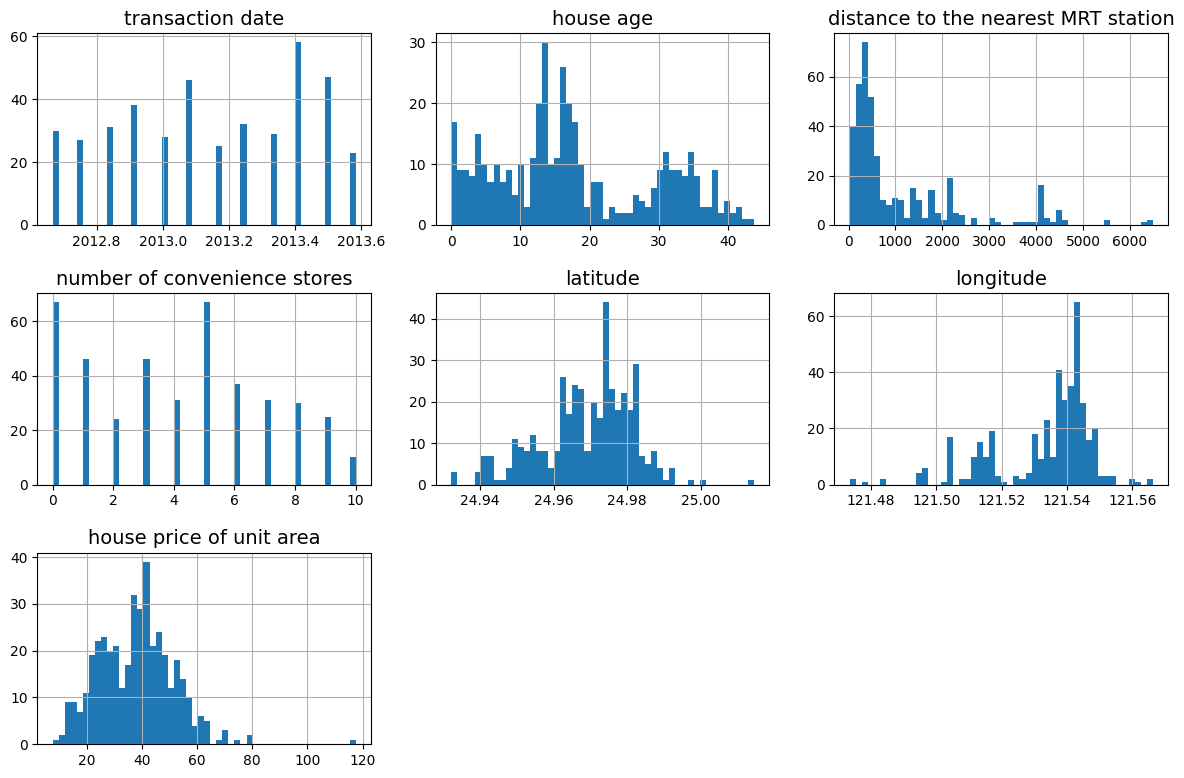

In [93]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

df.hist(bins=50, figsize=(12, 8))
save_fig("Tabela de distrubuição dos dados")
plt.show()

In [94]:
#configuração do geopandas para adicionar mapas no fundo do plot
gdf = geopandas.GeoDataFrame(
    df,
    geometry=geopandas.points_from_xy(df["longitude"], df["latitude"]),
    crs="EPSG:4326"
)

gdf = gdf.to_crs(epsg=3857)

Figure saved to: images/Mapeamento dos Preços por Ping de Imóveis.png


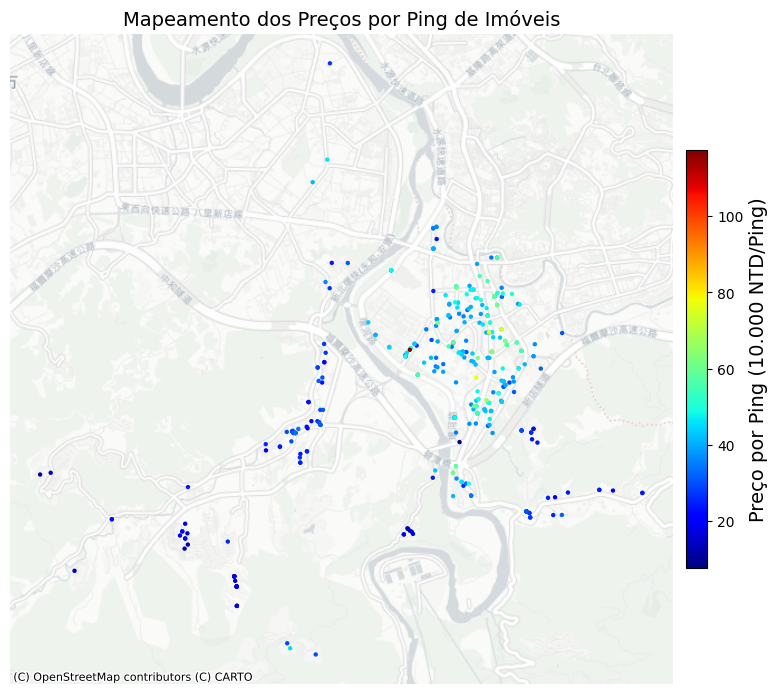

In [95]:
fig, ax = plt.subplots(figsize=(8,8))

gdf['house price of unit area'] = df['house price of unit area']

gdf_sorted = gdf.sort_values(by='house price of unit area', ascending=True)

g = gdf_sorted.plot(
    ax=ax,
    column="house price of unit area",
    cmap="jet",
    alpha=1,
    markersize=10,
    edgecolor="k",
    linewidth=0,
    legend=False
)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

ax.set_axis_off()
ax.set_aspect("equal")

sm = plt.cm.ScalarMappable(cmap="jet", norm=colors.Normalize(vmin=df['house price of unit area'].min(), vmax=df['house price of unit area'].max()))
cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
cbar.set_label("Preço por Ping (10.000 NTD/Ping)")
ax.set_title("Mapeamento dos Preços por Ping de Imóveis")
save_fig("Mapeamento dos Preços por Ping de Imóveis")
ax.set_axis_off()

Figure saved to: images/Mapeamento da Distância às Estações MRT Mais Próximas.png


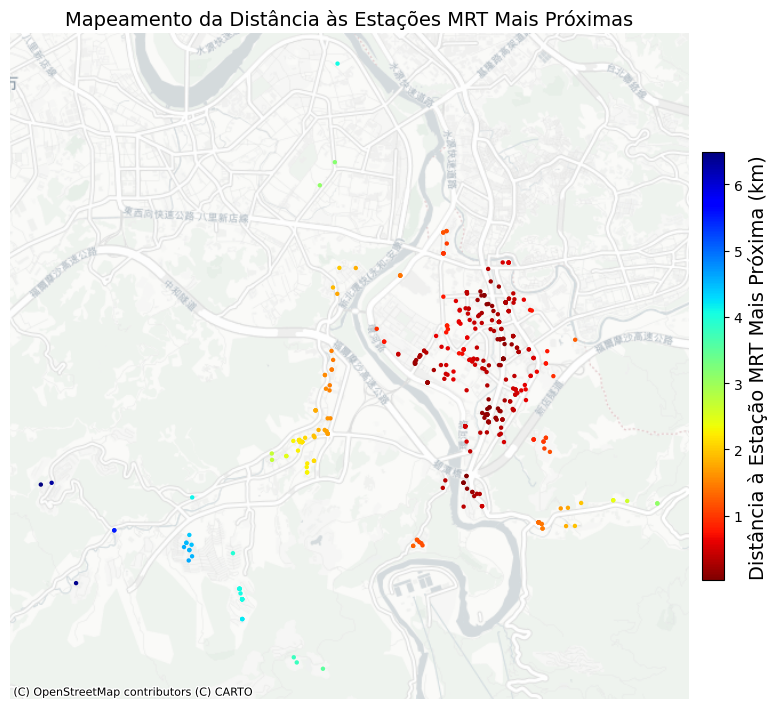

In [96]:
fig, ax = plt.subplots(figsize=(8,8))

gdf['distance to the nearest MRT station'] = df['distance to the nearest MRT station']

gdf_sorted = gdf.sort_values(by='distance to the nearest MRT station', ascending=True)

g = gdf_sorted.plot(
    ax=ax,
    column="distance to the nearest MRT station",
    cmap="jet_r",
    alpha=1,
    markersize=10,
    edgecolor="k",
    linewidth=0,
    legend=False
)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

ax.set_axis_off()

ax.set_aspect("equal")
ax.margins(0)

sm = plt.cm.ScalarMappable(cmap="jet_r", norm=colors.Normalize(vmin=df['distance to the nearest MRT station'].min()/1000, vmax=df['distance to the nearest MRT station'].max()/1000))
cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
cbar.set_label("Distância à Estação MRT Mais Próxima (km)")
ax.set_title("Mapeamento da Distância às Estações MRT Mais Próximas")
save_fig("Mapeamento da Distância às Estações MRT Mais Próximas")
ax.set_axis_off()

Figure saved to: images/Mapeamento do Número de Lojas de Conveniência.png


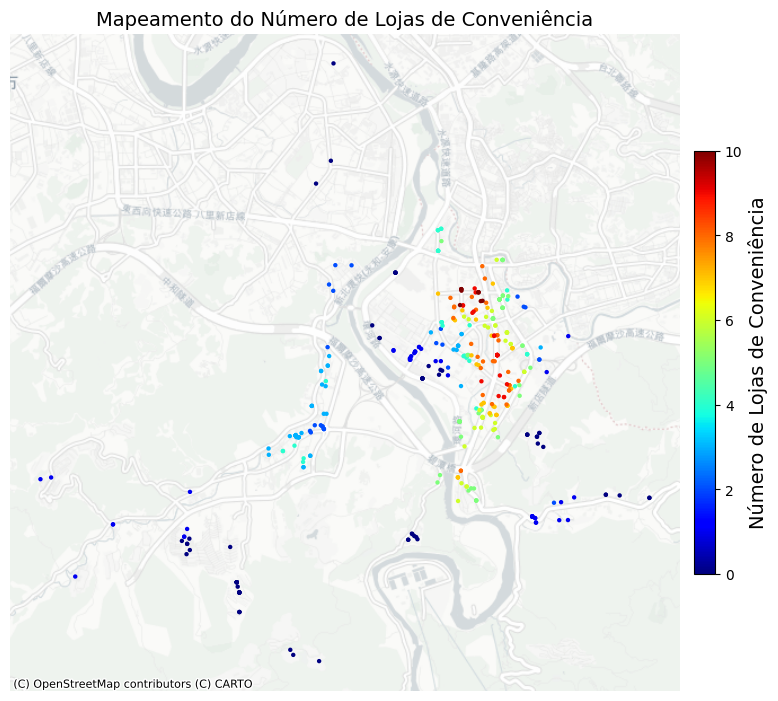

In [97]:
fig, ax = plt.subplots(figsize=(8,8))

gdf['number of convenience stores'] = df['number of convenience stores']

gdf_sorted = gdf.sort_values(by='number of convenience stores', ascending=True)

g = gdf_sorted.plot(
    ax=ax,
    column="number of convenience stores",
    cmap="jet",
    alpha=1,
    markersize=10,
    edgecolor="k",
    linewidth=0,
    legend=False
)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

ax.set_axis_off()

ax.set_aspect("equal")
ax.margins(0)

sm = plt.cm.ScalarMappable(cmap="jet", norm=colors.Normalize(vmin=df['number of convenience stores'].min(), vmax=df['number of convenience stores'].max()))
cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
cbar.set_label("Número de Lojas de Conveniência")
ax.set_title("Mapeamento do Número de Lojas de Conveniência")
save_fig("Mapeamento do Número de Lojas de Conveniência")
ax.set_axis_off()

In [98]:
corr_matrix = df.corr()
corr_matrix["house price of unit area"].sort_values(ascending=False)

,house price of unit area
house price of unit area,1.000000
number of convenience stores,0.571005
latitude,0.546307
longitude,0.523287
transaction date,0.087529
house age,-0.210567
distance to the nearest MRT station,-0.673613


Figure saved to: images/Matriz de Correlação.png


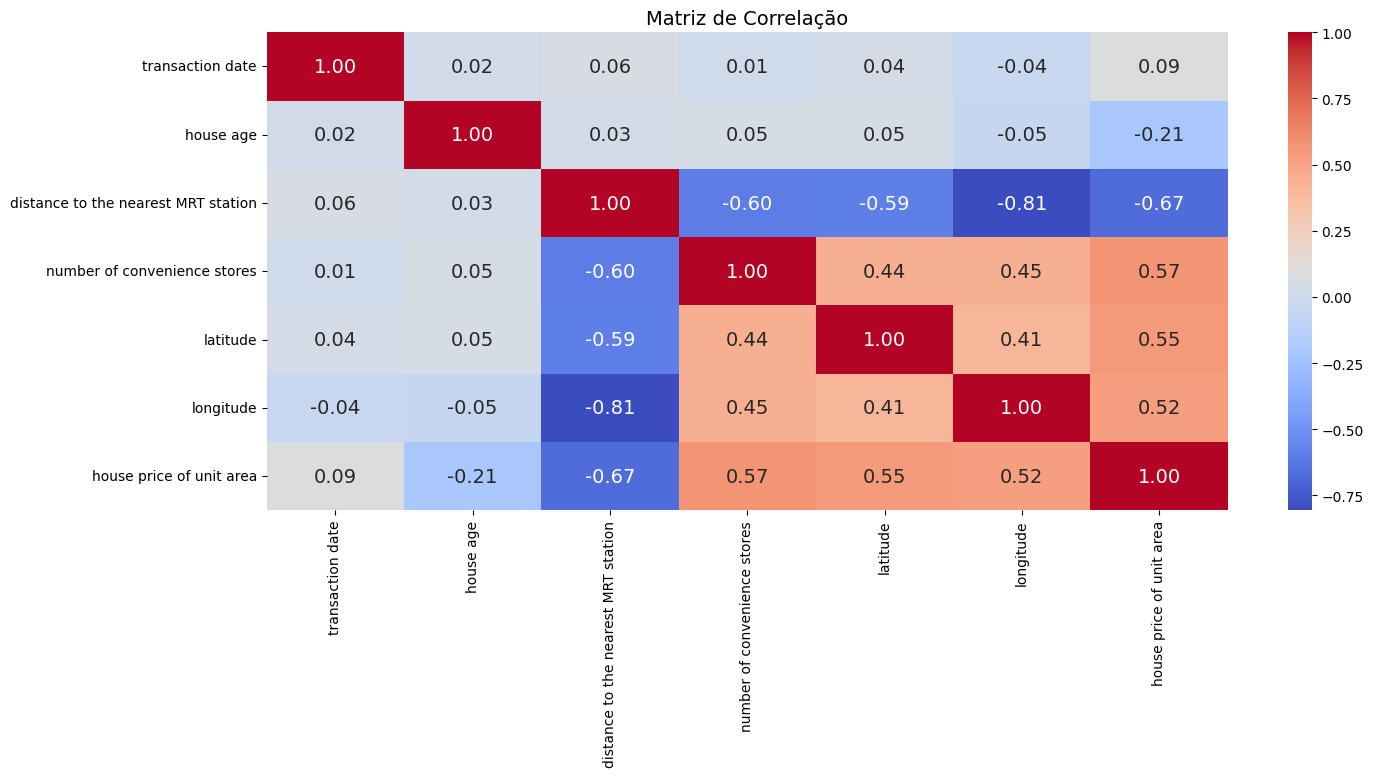

In [99]:
matrix = df.corr()

plt.figure(figsize=(15, 8))
sns.heatmap(
    matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)
plt.title("Matriz de Correlação")
save_fig("Matriz de Correlação")
plt.show()

Figure saved to: images/Pairplot.png


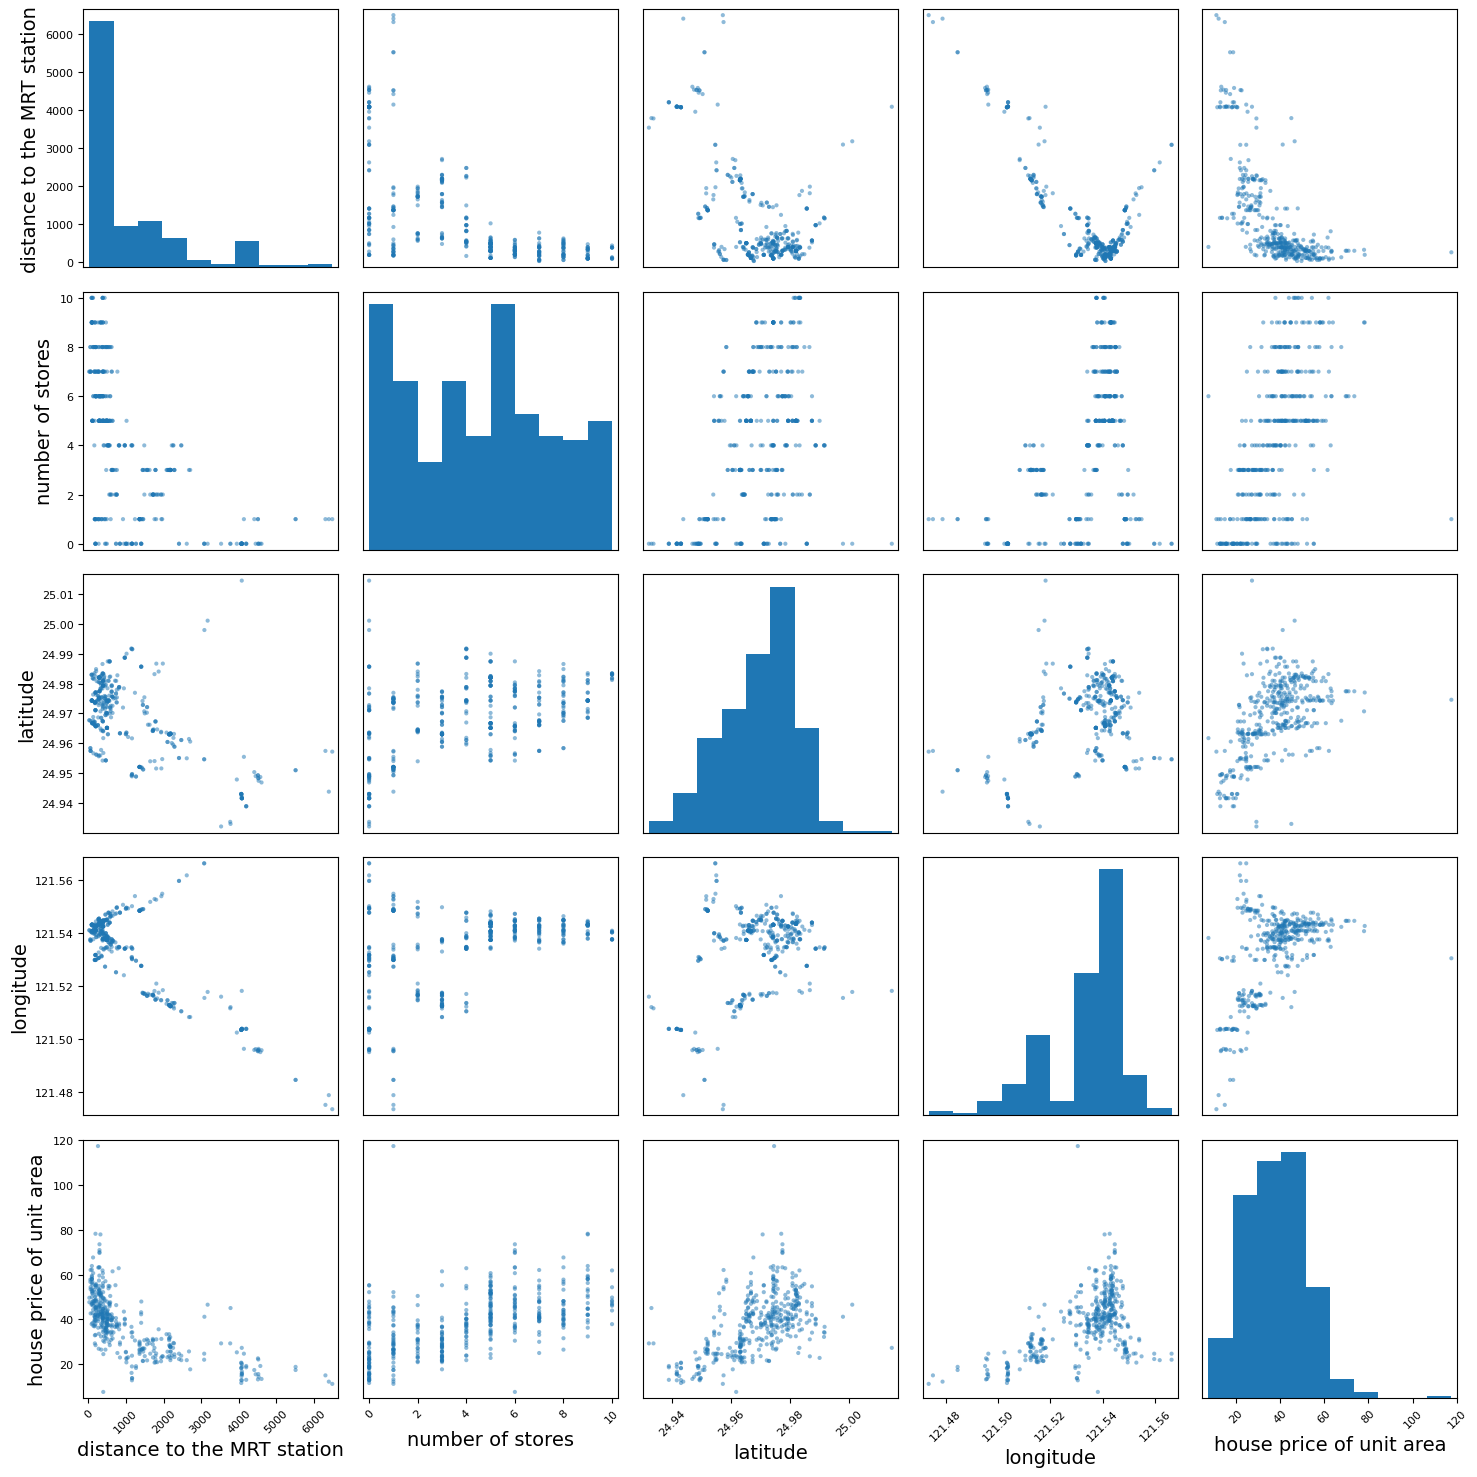

In [100]:
dfaux = df.drop(columns=(['transaction date','house age']));
dfaux = dfaux.rename(columns={
    'distance to the nearest MRT station': 'distance to the MRT station',
    'number of convenience stores': 'number of stores'
})

axes = scatter_matrix(dfaux, figsize=(15, 15), diagonal='hist')

plt.subplots_adjust(hspace=0.2, wspace=0.2)

for ax in axes.flatten():
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    ax.tick_params(axis='y', rotation=0, labelsize=8)

save_fig("Pairplot")
plt.show()

In [110]:
#aplicação do logaritmo para alinhar os dados da feature
X.loc[:, 'X3 distance to the nearest MRT station'] = np.log1p(X['X3 distance to the nearest MRT station'])

Figure saved to: images/Comparativo Distância MRT - Antes e Depois Log.png


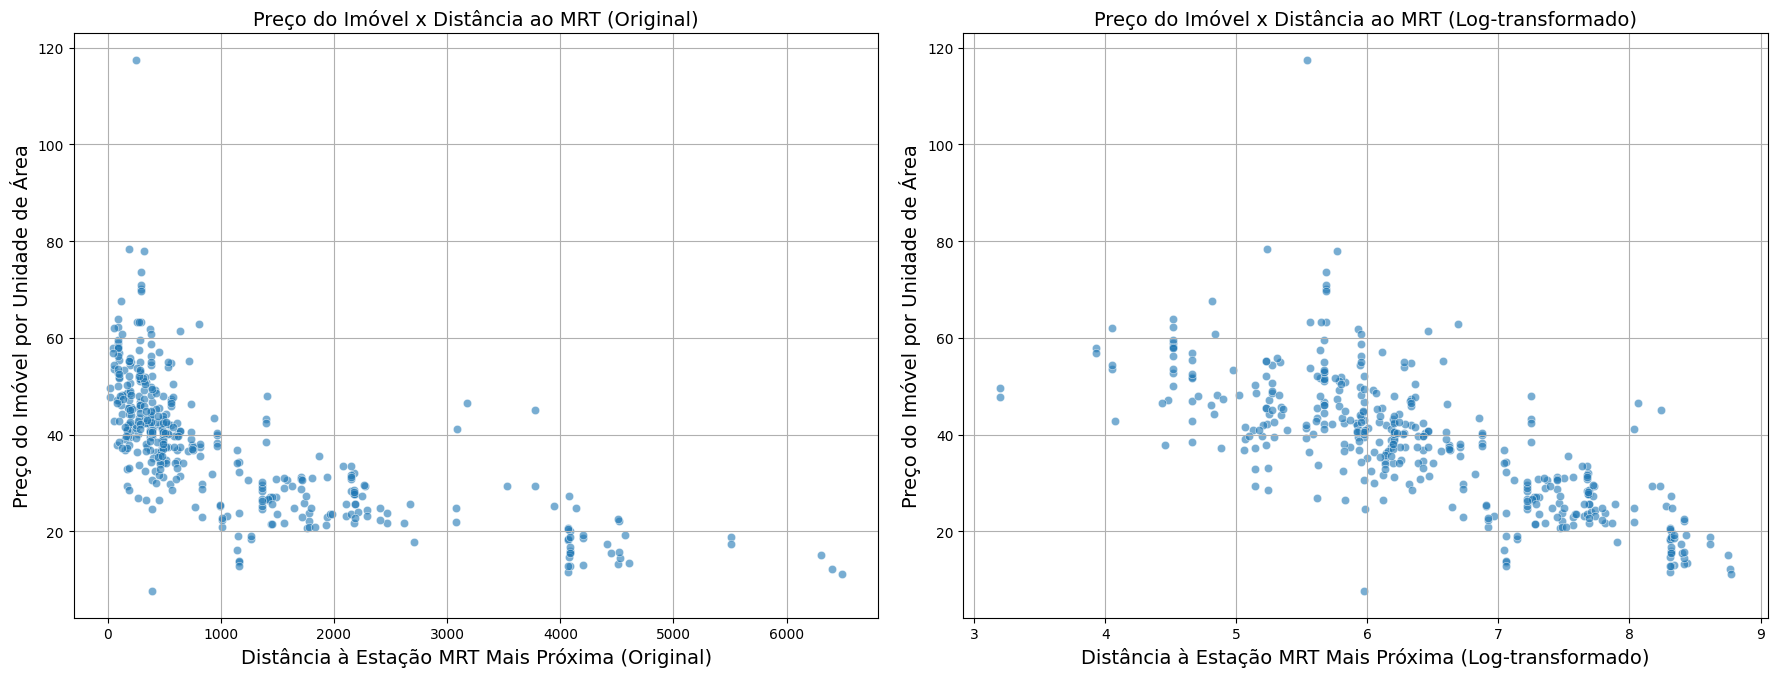

In [102]:
plt.figure(figsize=(18, 7))

plt.subplot(1, 2, 1)
sns.scatterplot(
    x=df_from_csv['X3 distance to the nearest MRT station'],
    y=y,
    alpha=0.6
)
plt.title('Preço do Imóvel x Distância ao MRT (Original)')
plt.xlabel('Distância à Estação MRT Mais Próxima (Original)')
plt.ylabel('Preço do Imóvel por Unidade de Área')
plt.grid(True)

plt.subplot(1, 2, 2)
sns.scatterplot(
    x=X['X3 distance to the nearest MRT station'],
    y=y,
    alpha=0.6
)
plt.title('Preço do Imóvel x Distância ao MRT (Log-transformado)')
plt.xlabel('Distância à Estação MRT Mais Próxima (Log-transformado)')
plt.ylabel('Preço do Imóvel por Unidade de Área')
plt.grid(True)

plt.tight_layout()
save_fig('Comparativo Distância MRT - Antes e Depois Log')
plt.show()

In [103]:
test=.20

print(f"Test size: {int((1-test)*100)}/{int(test*100)}:\n")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test, random_state=42
)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

coef_df = pd.DataFrame({
  "Variável": X.columns,
  "Coeficiente": model.coef_.flatten()
})

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(coef_df)
print(f"\nRMSE: {rmse}\nR2: {r2}\n")

Test size: 80/20:

                                 Variável  Coeficiente
0                     X1 transaction date     6.325999
1                            X2 house age    -0.241990
2  X3 distance to the nearest MRT station    -7.098920
3         X4 number of convenience stores     0.323167
4                             X5 latitude   283.781110
5                            X6 longitude    -5.828526

RMSE: 6.779050840648534
R2: 0.726063422238042



Figure saved to: images/Regressao_Distancia_MRT_e_Lojas_Conveniencia.png


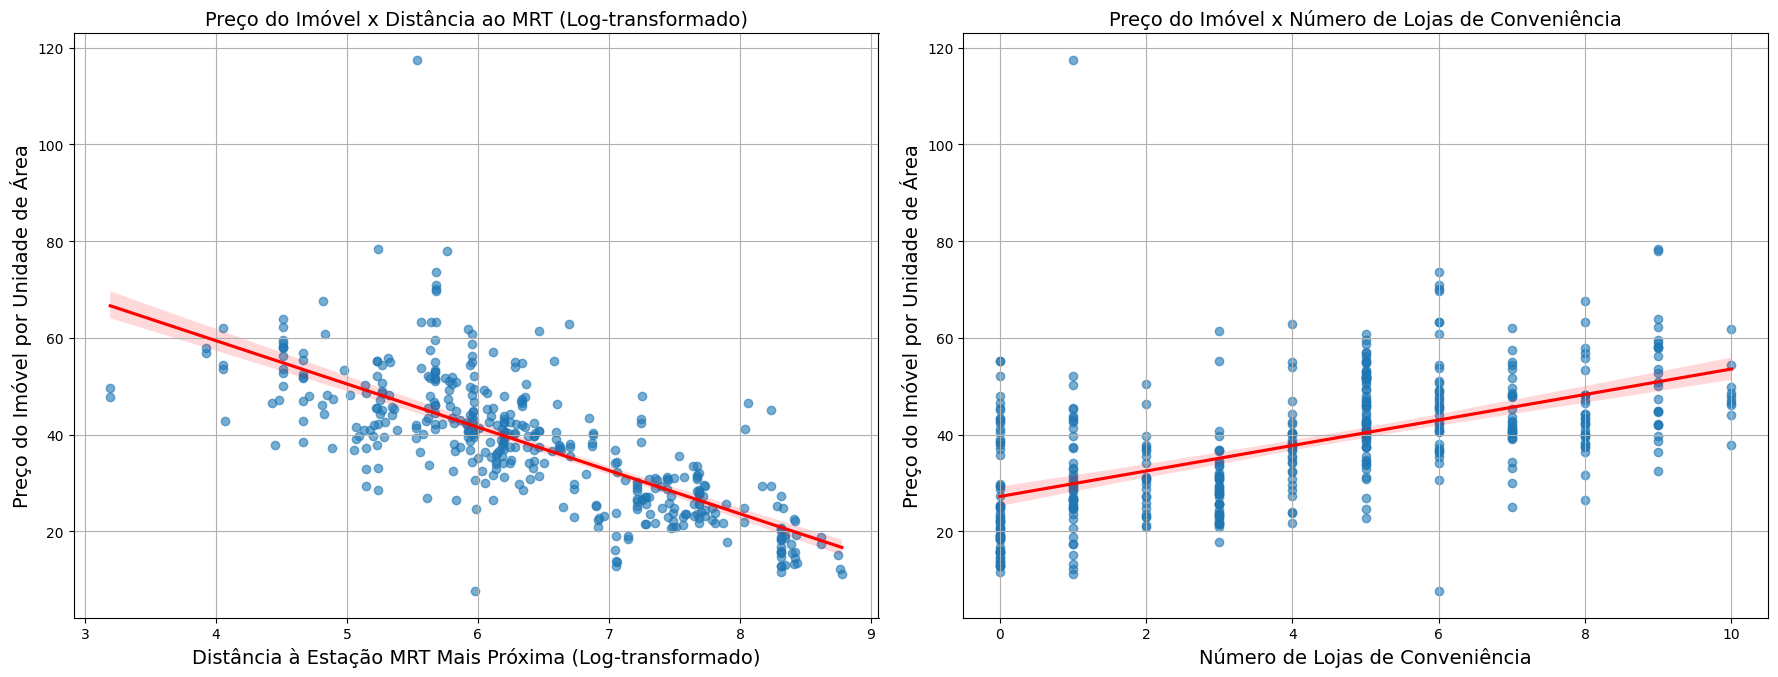

In [104]:
plt.figure(figsize=(18, 7))

plt.subplot(1, 2, 1)
sns.regplot(
    x=X['X3 distance to the nearest MRT station'],
    y=y,
    scatter_kws={'alpha':0.6},
    line_kws={'color':'red'}
)
plt.title('Preço do Imóvel x Distância ao MRT (Log-transformado)')
plt.xlabel('Distância à Estação MRT Mais Próxima (Log-transformado)')
plt.ylabel('Preço do Imóvel por Unidade de Área')
plt.grid(True)

plt.subplot(1, 2, 2)
sns.regplot(
    x=X['X4 number of convenience stores'],
    y=y,
    scatter_kws={'alpha':0.6},
    line_kws={'color':'red'}
)
plt.title('Preço do Imóvel x Número de Lojas de Conveniência')
plt.xlabel('Número de Lojas de Conveniência')
plt.ylabel('Preço do Imóvel por Unidade de Área')
plt.grid(True)

plt.tight_layout()
save_fig('Regressao_Distancia_MRT_e_Lojas_Conveniencia')
plt.show()